<a href="https://colab.research.google.com/github/stratoskar/Path-Based-Traffic-Flow-Prediction/blob/main/Python_Code/DataCollection_and_Trajectory_Splitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Data Collection**

The data used for this research comes from a project called the cabspotting project. Specifically, this dataset contains about 11.000.000 GPS data of various taxis (Yellow Cab Vehicles) in the San Francisco, California area. The whole data sampling occurred in May 2008.

<b>You can read more about the dataset in the following link: </b>https://stamen.com/work/cabspotting/

In [1]:
!pip install ipython-autotime

# Measure execution time of each cell
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.7 MB/s eta 0:00:00
time: 380 µs (started: 2023-12-10 18:00:03 +00:00)


In [3]:
# Library to load data files
import os

# Data analysis libraries
import numpy as np
import pandas as pd

# Cast timestamps library
from datetime import datetime, timedelta

time: 527 ms (started: 2023-12-10 18:00:14 +00:00)


In [5]:
# Access Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the path to the folder with the data
PATH = '/content/drive/MyDrive/Paper/Data/SanFranciscoCubs'

Mounted at /content/drive
time: 24.9 s (started: 2023-12-10 18:02:25 +00:00)


In [7]:
# taxi_id starts from 0
counter = 0

# Create an empty dataframe, in which all the data will be saved
all_data = pd.DataFrame(columns=['taxi_id','Latitude','Longitude','Occupied','Date Time'])

for filename in os.listdir(PATH):
    try:
      # Read each file in the Data folder
      temp = pd.read_csv(PATH+'/'+filename,names=['Latitude','Longitude','Occupied','Date Time'],sep=' ')

      # Assign taxi_id number to each file
      temp.insert(1,'taxi_id',counter)

      # Add the data in this file in the 'all_data' dataframe
      all_data = pd.concat([all_data, temp],ignore_index = True)

      # Increase taxi_id number by 1
      counter += 1
    except:
      continue

time: 2min 35s (started: 2023-12-10 18:05:15 +00:00)


In [8]:
#Change datetime field to timestamp
all_data['Date Time'] = pd.to_datetime(all_data['Date Time'],origin='unix',unit='s')

time: 6.71 s (started: 2023-12-10 18:07:50 +00:00)


In [9]:
# Sort the data based in taxi_id and timestamp information
all_data = all_data.sort_values(['taxi_id','Date Time'])
all_data = all_data.reset_index(drop=True)

time: 6.92 s (started: 2023-12-10 18:07:57 +00:00)


**Delete the 'Occupied' column**
This column denotes whether or not the taxi was occupied by a passenger during GPS recording. So, this information is not useful for our research.

In [10]:
all_data.drop('Occupied',axis=1,inplace=True)

time: 309 ms (started: 2023-12-10 18:08:04 +00:00)


**Present information about the dataset**

In [11]:
# Show the shape of the dataframe
all_data.shape

(11219955, 4)

time: 3.46 ms (started: 2023-12-10 18:08:06 +00:00)


In [12]:
# Print data types of every column present in the dataframe
all_data.dtypes

taxi_id              object
Latitude            float64
Longitude           float64
Date Time    datetime64[ns]
dtype: object

time: 10.3 ms (started: 2023-12-10 18:08:06 +00:00)


In [13]:
# Show schema information of the dataframe
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11219955 entries, 0 to 11219954
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   taxi_id    object        
 1   Latitude   float64       
 2   Longitude  float64       
 3   Date Time  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 342.4+ MB
time: 14.8 ms (started: 2023-12-10 18:08:06 +00:00)


In [14]:
# Present statistical insights about this dataframe
all_data.describe()

,Latitude,Longitude
count,1.121996e+07,1.121996e+07
mean,3.776360e+01,-1.224124e+02
std,5.386020e-02,3.578213e-02
min,3.286970e+01,-1.270814e+02
25%,3.775513e+01,-1.224253e+02
50%,3.778107e+01,-1.224111e+02
75%,3.779045e+01,-1.224003e+02
max,5.030546e+01,-1.155622e+02


time: 1.59 s (started: 2023-12-10 18:08:06 +00:00)


**Split the trajectories based on time field and FIle ID**

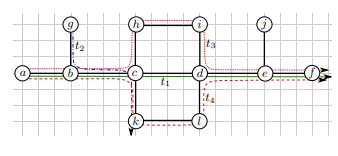

In the image above, we represent a road network. With the english letters a,b,c,d,e,f,g,h,i,j,k,l we denote the intersections. The black lines are the road segments between intersections.

Given a road network like this, the concept of trajectory splitting is the following:

**Each trajectory of a vehicle present in the dataset is broken into smaller pieces (sub-tracks) based on the following condition: 'Each sub-track shall contain consecutive position records for a single vehicle, which shall be separated in time by a maximum of two n_sec time units. The n_sec is defined by the user."**

In [15]:
# Insert a new column
all_data.insert(1,'traj_id',-1)

time: 35 ms (started: 2023-12-10 18:08:07 +00:00)


In [ ]:
'''
Each taxi_id contains GPS data of one trajectory

If the time gap between two GPS points is lower than n_sec seconds, (condition 1)
and these GPS points belong to the same taxi_id  (condition 2)
then asign the same traj_id number. (result)

If the time gap between two GPS points is higher than n_sec seconds, (condition 1)
and these GPS points belong to the same taxi_id  (condition 2)
then asign different traj_id number to each of these GPS points. (result)

If the GPS points belong to the same taxi_id  (condition)
then asign different traj_id number to each of these GPS points. (result)

'''

# Max number of seconds between GPS records of each traectory
n_sec = 90
traj_id = 0

for i in range(all_data.shape[0] -1):

    if (all_data['taxi_id'][i+1] == all_data['taxi_id'][i]): # Belong to the same taxi_id

        if (((all_data['Date Time'][i+1])-(all_data['Date Time'][i])).total_seconds() <= n_sec): # Tme interval less-equal than n_sec
            all_data.at[i,'traj_id'] = traj_id
            all_data.at[i+1,'traj_id'] = traj_id

        else: # Time interval higher than n_sec
            all_data.at[i,'traj_id'] = traj_id
            traj_id +=1
            all_data.at[i+1,'traj_id'] = traj_id

    else: # Not belong to the same taxi_id
        all_data.at[i,'traj_id'] = traj_id
        traj_id  = 0
        all_data.at[i+1,'traj_id'] = traj_id

time: 30min 51s (started: 2023-11-19 20:15:02 +00:00)


In [ ]:
# Print dataframe
all_data

,Taxi ID,Traj ID,Latitude,Longitude,Date Time
0,0,0,37.73515,-122.40484,2008-05-17 10:00:29
1,0,0,37.72245,-122.40081,2008-05-17 10:01:14
2,0,0,37.70973,-122.39541,2008-05-17 10:01:56
3,0,0,37.69660,-122.39249,2008-05-17 10:02:33
4,0,0,37.68318,-122.38942,2008-05-17 10:03:11
...,...,...,...,...,...
11224276,536,533,37.74332,-122.39649,2008-06-10 05:27:46
11224277,536,533,37.74996,-122.39307,2008-06-10 05:28:46
11224278,536,533,37.75201,-122.39383,2008-06-10 05:29:47
11224279,536,533,37.75161,-122.39392,2008-06-10 05:30:47


time: 23.1 ms (started: 2023-11-19 20:45:53 +00:00)


In [ ]:
# Save results
SAVE_PATH = '/content/drive/MyDrive/Paper/Files/splitted_data.csv'
all_data.to_csv(SAVE_PATH,index=False)

time: 1min 21s (started: 2023-11-19 20:45:53 +00:00)


The file that was created, will be used in the next code file.
The next code file has the title of 'Map Matching'